# Investigation of the Equilibrium Paths of the Unreinforced Box Beam

In our previous notebooks we have established that the equilibrium path of a box beam, whether unreinforced or reinforced, is always stable and resembles the one of a broken supercritical pitchfork bifurcation. In the case of Euler's column, the broken bifurcation path is accompanied by the presence of a complimentary path that cannot be reached from the ground state. As a consequence, a legitimate question arises: is there any complimentary path also in the case of the box beam?

A clue on the existence of complimentary paths for the box beam comes from the sensitivity study of the nonlinear analysis parameters that we carried out for the [box beam reinforced with ribs](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-analysis-parameters) and [with ribs and stiffeners](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb#nonlinear-analysis-parameters). In those cases we observed some differences in the load-displacement curves obtained using different nonlinear analysis parameters, and we attributed those differences to the varying accuracy of the solution, caused in turn by the different parameters used for the analysis. However, is it possible that the equilibrium points of those curves actually belong to different disconnected equilibrium paths?

In this notebook we are going to investigate the possible presence of other paths in the equilibrium manifold of the unreinforced box beam, playing with the nonlinear analysis parameters to find those paths.

* [Setup of the numerical model](#numerical-model)
* [Variation of nonlinear analysis parameters](#nonlinear-analysis-parameters)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
* [Verification of the existence of other equilibrium paths](#verification)
* [Visualization of 3D equilibrium diagram and of deformation shapes](#visualization)
* [Conclusions](#conclusions)

## Setup of the numerical model <a name="numerical-model"></a>

***

Let's consider the same unreinforced box beam used in our previous notebooks.

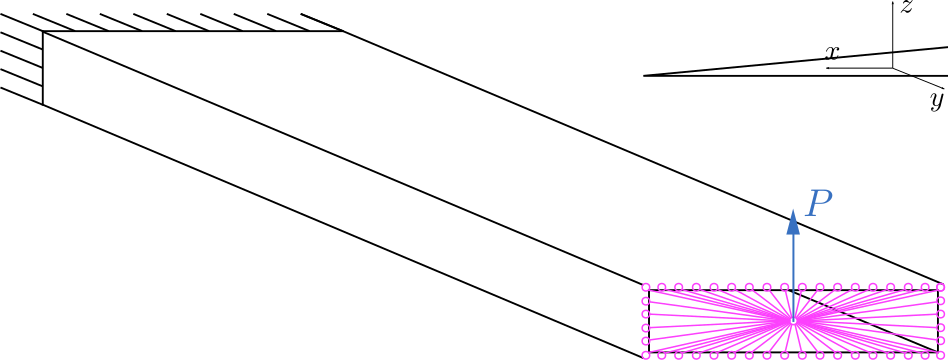

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [2]:
# Define geometry
AR = 9.   # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
l = AR*w/2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- length: {l/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

# Define material
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

Box beam dimensions:
- width: 1.0 m
- length: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


Let's define the mesh using a shell element of 86 mm, as found in a previous [mesh convergence study](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#mesh-convergence). We use the function `mesh_box_with_pyvista` from the `box_beam_utils` module and then we call the function `create_base_bdf_input` from the same module, which generates a `BDF` object of our box beam with material properties, nodes, elements, boundary conditions and output files defaults. Finally, let's print the cards of the `BDF` object.

In [3]:
from resources import box_beam_utils

shell_element_length = 86  # [mm]
box_beam_mesh = box_beam_utils.mesh_box_with_pyvista(width=w, length=l, height=h, element_length=shell_element_length)
nodes_coordinates_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                    nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now we add a concentrated upward force at the center of the tip section rigidly constraining the nodes of the section to the center.

In [4]:
import numpy as np

# Add master node of tip section
tip_master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf.add_grid(tip_master_node_id, [w/2, l, 0.])

# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1]==l]
rbe2_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe2(rbe2_eid, tip_master_node_id, '123456', tip_nodes_ids)

# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf.add_force(sid=force_set_id, node=tip_master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

FORCE         11    1761              1.      0.      0.      1.

Finally we set up the arc-length method with default parameters calling the function `set_up_arc_length_method` from the `pynastran_utils` module.

In [5]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

pynastran_utils.set_up_arc_length_method(box_beam_bdf)  # set up SOL 106 with arc-length method using default parameters

## Variation of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

How can we find whether any complimentary path exist in the equilibrium manifold of our box beam? As mentioned earlier, we can get a clue from our previous sensitivity studies on the nonlinear analysis parameters. For the box beam reinforced with ribs and with ribs and stiffeners we observed different load-displacement curves when varying certain parameters. The idea here is to select the parameters that result in different load-displacement curves and then for each value leading to a different final equilibrium point we run an analysis with two subcases. In the first subcase we use the parameters to reproduce the final equilibrium point and in the second subcase we unload the structure with a very fine arc-length, with the aim of tracking the equilibrium path very accurately. In this way we will be able to verify whether the final equilibrium points belong to different paths.

When we carried out the sensitivity study on the nonlinear analysis parameters for the [unreinforced box beam](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb), we only loaded the structure up to the buckling load predicted by SOL 105, $P_\text{SOL 105}$, instead of twice its value, and consequently we did not observe any influence of the parameters on the load-displacement curves. For this reason, we are going to perform the sensitivity study again, this time loading the structure with $P/P_\text{SOL 105}=2$, until we find a parameter leading to different load-displacement curves. Once identified the parameter, we'll try to run an analysis with two subcases as described earlier.

To perform the sensitivity study let's first define a subcase with an applied load of $P/P_\text{SOL 105}=2$. We recall the buckling load predicted by SOL 105 for our box beam, add a LOAD card, and call the function `create_static_load_subcase` from the `pynastran_utils` module.

In [6]:
sol_105_buckling_load = 1657.  # [N]
load_set_id = force_set_id + 1  # define id of LOAD card
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[2*sol_105_buckling_load], load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set

### Error function <a name="error-function"></a>

Let's start by considering different combinations of error functions:
- load and energy (default);
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking.

In [7]:
# Define error functions
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']

To run the analyses with the different parameter settings, we first define the name of the analysis directory and then we define the function `plot_load_displacement_curve` to run the analysis and plot the resulting load-displacement curve on an already existing figure. We monitor the tip displacement $u_{z, tip}$ and nondimensionalize it with the length $l$ of the box beam.

In [8]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
from pyNastran.op2.op2 import read_op2  # function to read Nastran op2 files

analysis_directory_name = '14_Investigation_of_the_Equilibrium_Paths_of_the_Unreinforced_Box_Beam'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

markers = list(Line2D.markers.keys())[2:]  # list of marker characters
component_index = 2  # index of the component of interest for displacements and loads (translation along z)

def plot_load_displacement_curve(bdf_input, filename, axes, marker_style, line_label):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=False)
    # Read load and displacement history from op2 file
    op2_filepath = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_filename=op2_filepath, debug=None)
    _, p, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_master_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,component_index]/l, p[1][:, component_index]/sol_105_buckling_load, marker=marker_style, linestyle='-', label=line_label)

Let's find the load-equilibrium curves for the different combinations of error functions.

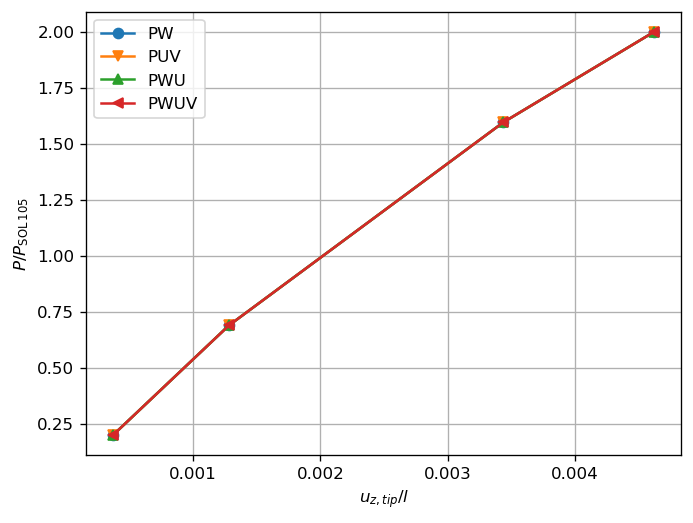

In [9]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
nlparm_id = next(iter(box_beam_bdf.nlparms))  # retrieve id of NLPARM card
ax = plt.subplot()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf.nlparms[nlparm_id].conv = fun
    input_filename = 'nonlinear_analysis_error_function_' + fun
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, markers[count], f'{fun}')

# Set plot appearance
plt.xlabel('$u_{z, tip}/l$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

Since we cannot observe any effect on the load-displacement curve, we restore the default value and move on to the next nonlinear analysis parameter.

In [10]:
box_beam_bdf.nlparms[nlparm_id].conv = 'PW'

### Convergence tolerances <a name="error-function"></a>

We consider three different combinations of convergence tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL 106 models :
- $EPSP=10^{-1}$, $EPSW=10^{-1}$;
- $EPSP=10^{-2}$, $EPSW=10^{-3}$;
- $EPSP=10^{-3}$, $EPSW=10^{-7}$,

where $EPSP$ and $EPSW$ are the convergence tolerances for the load function and the energy function, respectively. The default values are $EPSP=10^{-2}$ and $EPSW=10^{-2}$.

Let's define the lists of convergence tolerances, run the analyses and visualize the results.

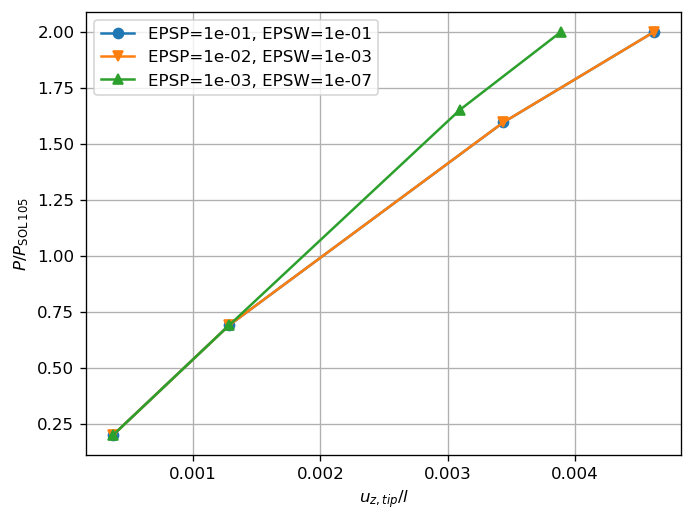

In [11]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
ax = plt.subplot()
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf.nlparms[nlparm_id].eps_p = epsp
    box_beam_bdf.nlparms[nlparm_id].eps_w = epsw
    input_filename = f'nonlinear_analysis_load_tolerance_{epsp:.0e}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}')

# Set plot appearance
plt.xlabel('$u_{z, tip}/l$')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

We observe that while the combination of $EPSP=10^{-1}$, $EPSW=10^{-1}$ and of $EPSP=10^{-2}$, $EPSW=10^{-3}$ produce the same load-displacement curves, for $EPSP=10^{-3}$, $EPSW=10^{-7}$ we get different equilibrium points. Let's find out whether these belong to a different equilibrium path with respect to the other points.

## Verification of the existence of other equilibrium paths <a name="verification"></a>

***

We run a first analysis considering the curve obtained using $EPSP=10^{-3}$ and $EPSW=10^{-7}$. We define the two subcases with the following nonlinear analysis parameters:

1. concentrated tip load, $EPSP=10^{-3}, EPSW=10^{-7}$, default remaining parameters;
2. no load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$.

In the second subcase we use $\Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$ to obtain a very fine resolution of the equilibrium path while unloading the structure.

In [12]:
# Define load set with zero applied force
zero_load_set_id = load_set_id + 1  # id of LOAD card
box_beam_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])  # add LOAD card

# Create second subcase to unload the structure
second_subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=second_subcase_id, load_set_id=zero_load_set_id)  # create subcase with zero applied load
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, nlparm_id=second_subcase_id, eps_p=1e-3, eps_w=1e-7, ninc=100, desiter=5, maxalr=1.01, maxinc=34,
subcase_id=second_subcase_id)  # set up arc-length method for second subcase using parameters for very fine resolution of equilibrium path

Let's run the analysis by calling the function `run_tangent_stiffness_matrix_eigenvalue_calculation` from the `pynatran_utils` module. This function sets up the `BDF` object to calculate the lowest eigenvalue of the tangent stiffness matrix, runs the analysis, reads the resulting op2 file and returns the corresponding `OP2` object.

In [13]:
input_name = 'path_existence_verification_2Psol105_epsp1e-3'
sol_106_op2_2Psol105_epsp1em3 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1, analysis_directory_path=analysis_directory_path,
    input_name=input_name, run_flag=False)

Nastran job path_existence_verification_2Psol105_epsp1e-3.bdf completed
Wall time: 39.0 s


Once we have run the analysis, we want to plot the load-displacement diagram and the eigenvalues $\lambda$ of the tangent stiffness matrix $\mathbf{K}_T$. In order to to this we define two functions.

In the first function, `plot_load_displacement_diagram` we take as input the displacement and load history of all subcases, we create a new figure and we plot the applied load and the displacement for every converged iteration of each subcase. For this plot we always consider the tip displacement $u_z$ nondimensioanlized with the length $l$ of the box beam.

In the second function, `plot_tangent_stiffness_matrix_eigenvalues` we take as input the path to the analysis directory, the name of the Nastran input file and the load history of all subcases. The function reads the eigenvalues of the tangent stiffness matrix from the f06 file, and creates a new figure with two subplots. It then plots the eigenvalues against the iteration number in the first subplot and the eigenvalues against the applied loads in the second subplot. In this way we can observe how the eigenvalues evolve both as the nonlinear analysis walks forward through the subcases and in relation with the applied loads.

In [14]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors

def plot_load_displacement_diagram(disp, loads):
    load_displacement_ax = plt.subplot()  # create figure with one subplot
    for subcase in loads:  # iterate through the subcases
        load_displacement_ax.plot(disp[subcase][:, component_index]/l, loads[subcase][:, component_index]/sol_105_buckling_load, marker=markers[subcase - 1],
                                   label=f'Subcase {subcase:d}')  # plot applied loads against displacement for each converged iteration
    load_displacement_ax.legend()  # set up legend
    plt.xlabel('$u_{z, tip}/l$')
    plt.ylabel('$P/P_\mathrm{SOL\/105}$')
    plt.grid()
    plt.show()

def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues from f06 file
    f06_path = os.path.join(directory_path, input_name + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    iterations_count = 1
    # Divide lowest eigenvalues by subcase and plot them
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase in loads:
        no_load_steps = len(loads[subcase])
        eigenvalues_by_subcase[subcase] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number in first subplot
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase].shape[1] + iterations_count), eigenvalues_by_subcase[subcase].T, markers[subcase - 1],
        color=colors[subcase - 1], label=f'Subcase {subcase:d}')
        iterations_count += eigenvalues_by_subcase[subcase].shape[1]
        # Plot eigenvalues vs applied load in second subplot
        eigvals_axs[1].plot(loads[subcase][:eigenvalues_by_subcase[subcase].shape[1], component_index]/sol_105_buckling_load, eigenvalues_by_subcase[subcase].T,
        markers[subcase - 1], color=colors[subcase - 1])
    # Set plot appearance
    eigvals_axs[0].set_xlabel('Iteration')
    eigvals_axs[0].set_ylabel('$\lambda$, N/mm')
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    eigvals_axs[1].grid(visible=True)
    plt.show()


Let's read the load-displacement history from the `OP2` object returned by the function `run_tangent_stiffness_matrix_eigenvalue_calculation` and plot both the load-displacement and the eigenvalue diagram.

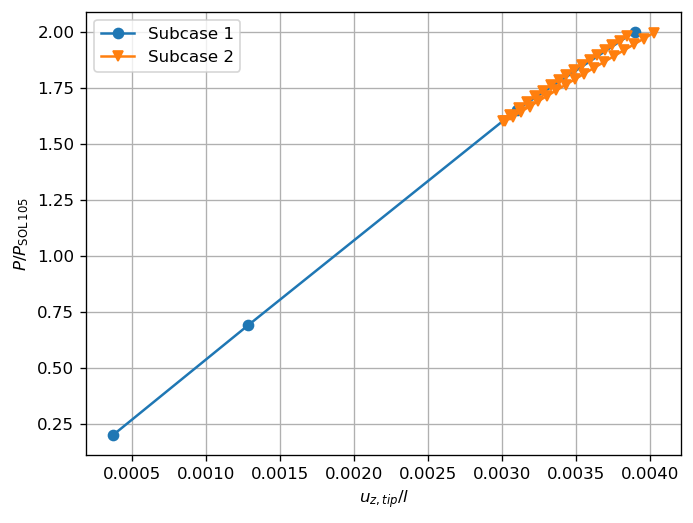

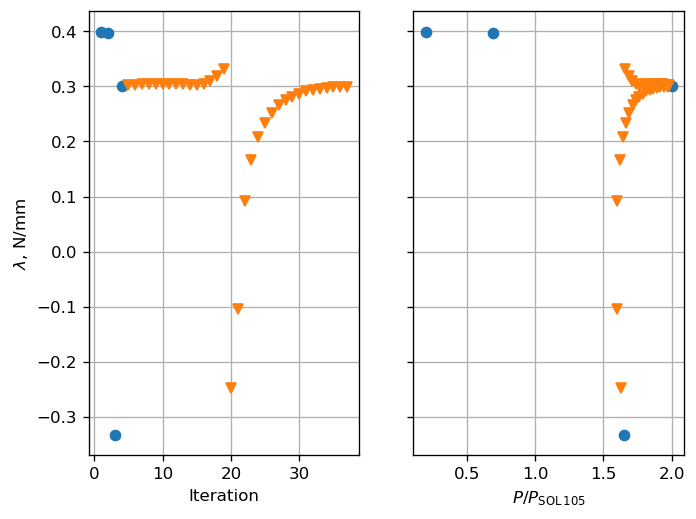

In [15]:
_, applied_loads_2Psol105_epsp1em3, tip_displacements_2Psol105_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_2Psol105_epsp1em3, displacement_node_id=tip_master_node_id)
plot_load_displacement_diagram(tip_displacements_2Psol105_epsp1em3, applied_loads_2Psol105_epsp1em3)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_2Psol105_epsp1em3)

What a surprise in the load-displacement diagram! When we try to unload the structure from the final point of the first subcase, we are actually not able to do it. The load and displacement initially decrease, but around $P/P_\text{SOL 105}=1.6$ they spring back along a different trajectory.

What's the nature of this new path that we have found? Looking at the eigenvalue diagram, it looks like we have negative eigenvalues and consequently unstable equilibrium points for at least a portion of the path. We also observe a negative eigenvalue at the third converged iteration of the first subcase. However, the lowest eigenvalue of the tangent stiffness matrix appears to have a discontinuous behavior during the analysis. Why is that? This is most probably related to the fact that we are using the Lanczos method to calculate the eigenvalues of $\mathbf{K}_T$. In fact, the Lanczos method calculates the first $N$ eigenvalues of a matrix from the lowest in magnitude to the largest. When we see a jump in the plot above, it is well possible that there is a change in which eigenvalue is the lowest in magnitude.

For this reason, we rerun the analysis calculating more than one eigenvalue of $\mathbf{K}_T$, setting $N=10$.

In [16]:
no_eigenvalues = 10
input_name = f'path_existence_verification_2Psol105_epsp1e-3_{no_eigenvalues:d}eigenvalues'
sol_106_op2_2Psol105_epsp1em3 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

Nastran job path_existence_verification_2Psol105_epsp1e-3_10eigenvalues.bdf completed
Wall time: 53.0 s


Let's read the load history and plot the eigenvalue diagram.

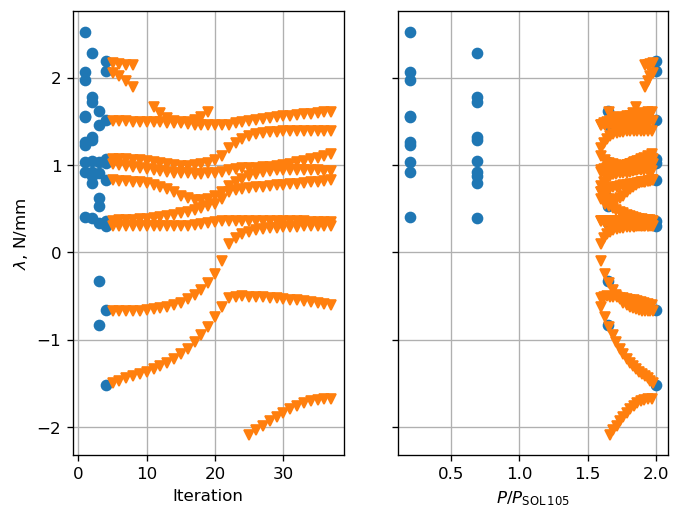

In [17]:
_, applied_loads_2Psol105_epsp1em3, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_2Psol105_epsp1em3, displacement_node_id=tip_master_node_id)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_2Psol105_epsp1em3)

From this plot we can observe that the last two iterations of the first subcase show negative eigenvalues of $\mathbf{K_T}$, meaning that the structure ends up on an unstable equilibrium path. This is different from what we observed in a [previous analysis](06_Verification_of_SOL_106_Nonlinear_Buckling_Method.ipynb#tangent-stiffness-matrix) on the unreinforced box beam, where its natural path, that is to say the path connected to the ground state, was always stable. In this case, the jump to another equilibrium path must be ascribed to the very large arc-length used for the analysis, which allows the solver to find equilibrium points that are not on the natural path.

In the second subcase, we see one eigenvalue transitioning from negative to positive, while at least another one is negative for all iterations. This means that the entire path described in the second subcase is unstable. We should note that there may exist other negative eigenvalues of $\mathbf{K_T}$ and, if we wanted to investigate that, we would need to run the analysis with a larger value of $N$.

Now we want to get an additional proof that the newly found path is disconnected from the natural path of the box beam. For this reason, we are going to change the second subcase to unload the structure using a load-controlled Newton method. Our expectation is that, around $P/P_\text{SOL 105}=1.6$, we should observe a jump in both the load-displacement and in the eigenvalue diagrams. This is because the load-control nature of the Newton method will constrain the load to decrease even if there is no solution on the current equilibrium path, forcing the solver to find a solution on another path, which hopefully will correspond to the natural path.

Let's modify our `BDF` object by removing the NLPCI card, to enable the Newton method, and by increasing the maximum number of iteration for each load increment.

In [18]:
del box_beam_bdf.nlpcis[2]  # remove NLPCI card
box_beam_bdf.nlparms[2].max_iter = 50  # increase maximum number of iterations for each load increment, needed to converge the iteration where the jump happens

Now let's run the analysis and plot both the load-displacement and the eigenvalue diagrams.

Nastran job path_existence_verification_2Psol105_epsp1e-3_10eigenvalues_newton.bdf completed
Wall time: 123.0 s


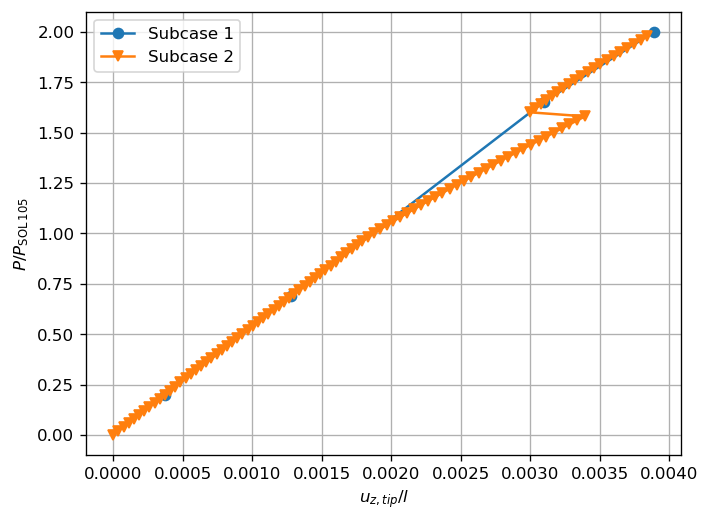

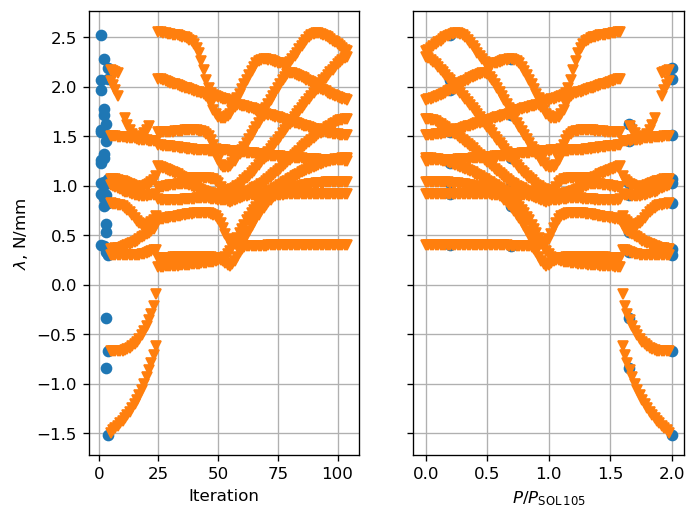

In [19]:
input_name = f'path_existence_verification_2Psol105_epsp1e-3_{no_eigenvalues:d}eigenvalues_newton'
sol_106_op2_2Psol105_epsp1em3_newton = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)
_, applied_loads_2Psol105_epsp1em3_newton, tip_displacements_2Psol105_epsp1em3_newton = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_2Psol105_epsp1em3_newton, displacement_node_id=tip_master_node_id)
plot_load_displacement_diagram(tip_displacements_2Psol105_epsp1em3_newton, applied_loads_2Psol105_epsp1em3_newton)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_2Psol105_epsp1em3_newton)

We can definitely observe a jump in both diagrams around $P/P_\text{SOL 105}=1.6$, so our expectation is confirmed! When the Newton solver tries to find an equilibrium point for an applied load that is lower than the minimum on the unstable path, it jumps to the natural path and continues unloading the structure to the ground state.

What happens for $EPSP=10^{-2}$, $EPSW=10^{-3}$ and for $EPSP=10^{-1}$, $EPSW=10^{-1}$? Let's investigate it, starting from $EPSP=10^{-2}$, $EPSW=10^{-3}$.

We define the following two subcases:

1. concentrated tip load, $EPSP=10^{-2}, EPSW=10^{-3}$, default remaining parameters;
2. no load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$.

In the second subcase we use $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$ to obtain a very fine resolution of the equilibrium path while unloading the structure. Let's modify the convergence tolerance for the first subcase, turn back on the arc-length method, load the structure up to $P/P_\text{SOL 105}=2$, run the analysis and plot the results.

Nastran job path_existence_verification_2Psol105_epsp1e-2.bdf completed
Wall time: 55.0 s


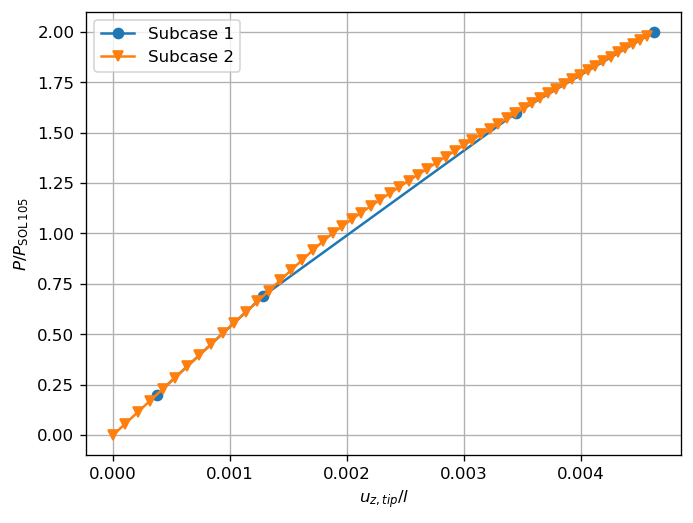

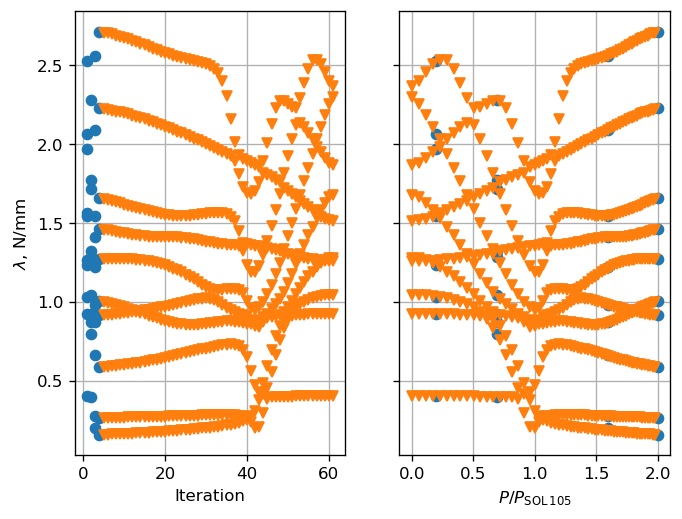

In [20]:
# Modify convergence tolerances of first subcase
box_beam_bdf.nlparms[1].eps_p = 1e-2
box_beam_bdf.nlparms[1].eps_w = 1e-3

# Reactivate arc-length method for second subcase
box_beam_bdf.add_nlpci(nlpci_id=second_subcase_id, Type='CRIS', maxalr=1.01, desiter=5, mxinc=100)

# Load the structure with twice the buckling load of SOL 105
load_factor = 2  # define multiplicative factor
box_beam_bdf.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_load*load_factor  # modify scale factor of LOAD card

# Run analysis
input_name = f'path_existence_verification_{load_factor:.0f}Psol105_epsp1e-2'.replace('.','_')
sol_106_op2_2Psol105_epsp1em2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)  # run analysis and read OP2 file

# Plot results
_, applied_loads_2Psol105_epsp1em2, tip_displacements_2Psol105_epsp1em2 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_2Psol105_epsp1em2, displacement_node_id=tip_master_node_id)  # find load and displacement history
plot_load_displacement_diagram(tip_displacements_2Psol105_epsp1em2, applied_loads_2Psol105_epsp1em2)  # plot load-displacement diagram
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_2Psol105_epsp1em2)  # plot eigenvalue diagram

In this case, our box beam gets completely unloaded during the second subcase, meaning that the solver is able to move along the natural path of the structure. In fact, we can observe that all the calculated eigenvalues of $\mathbf{K_T}$ are always positive, both in the first and in the second subcase. This means that for all equilibrium points calculcated in this analysis, the box beam is in a stable equilibrium.

Now let's have a look at what happens for $EPSP=10^{-1}$, $EPSW=10^{-1}$. We run the analysis and plot the results using the following two subcases:

1. concentrated tip load, $EPSP=10^{-1}, EPSW=10^{-1}$, default remaining parameters;
2. no load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$.

Nastran job path_existence_verification_2Psol105_epsp1e-2.bdf completed
Wall time: 55.0 s


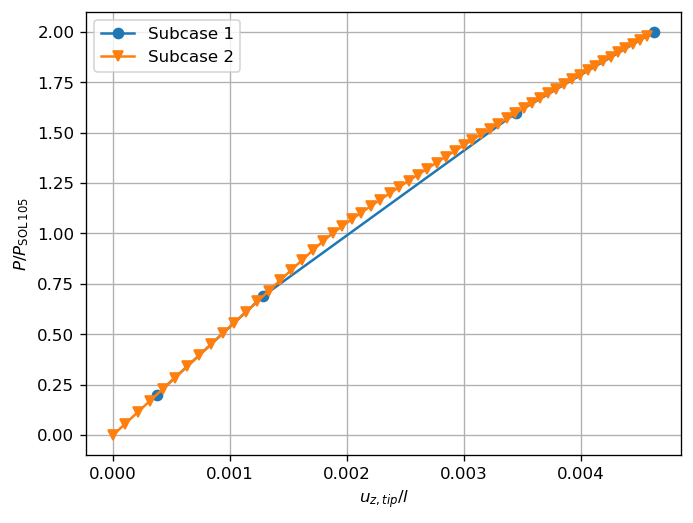

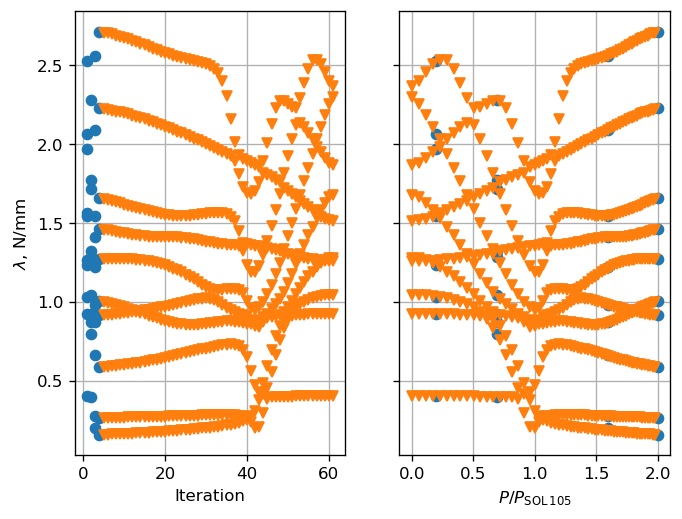

In [21]:
# Modify convergence tolerance of first subcase
box_beam_bdf.nlparms[1].eps_p = 1e-1
box_beam_bdf.nlparms[1].eps_w = 1e-1

# Run analysis
input_name = f'path_existence_verification_{load_factor:.0f}Psol105_epsp1e-2'.replace('.','_')
sol_106_op2_2Psol105_epsp1em1 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)  # run analysis and read OP2 file

# Plot results
_, applied_loads_2Psol105_epsp1em1, tip_displacements_2Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_2Psol105_epsp1em1, displacement_node_id=tip_master_node_id)  # find load and displacement history
plot_load_displacement_diagram(tip_displacements_2Psol105_epsp1em1, applied_loads_2Psol105_epsp1em1)  # plot load-displacement diagram
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_2Psol105_epsp1em1)  # plot eigenvalue diagram

Also in this case we see that the our box beam is fully unloaded in the second subcase and that it is always in a stable equilibrium.

## Visualization of 3D equilibrium diagram and deformation shapes <a name="visualization"></a>

***

Now we want to visualize together the natural path and the unstable path that we found earlier. Doing this on a 2D equilibrium path where we look only at the tip displacement would most probably not result more insigthful than our previous plots. So how can we achieve a better characterization of the differences among the paths? If we consider the tip displacement as a surrogate of the global deformation state of the structure, we could think of another surrogate giving us an idea of the local deformation state. In that way, we could plot a 3D load-displacement diagram with the applied load against the tip and the local displacement.

Considering the nonlinear deformation shape of the box beam obtained in our previous analyses, an appropriate choice for the local displacement could be the displacement along the $z$-axis of the node where we observe the maximum displacement in a linear buckling analysis (SOL 105). As a consequence, we delete our previous subcases and call the function `run_sol_105_buckling_analysis` from the `pynastran_utils` module to find the id of the node where the maximum displacement occurs.

In [22]:
# Delete subcases 1 and 2
for subcase_id in range(1, 3):
    del box_beam_bdf.subcases[subcase_id]

# Run linear buckling analysis
input_name = 'path_existence_verification_sol_105'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=box_beam_bdf.__deepcopy__({}), static_load_set_id=force_set_id,
analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

# Find id of node where maximum displacement occurs
max_displacement_node_id = np.argmax(sol_105_op2.eigenvectors[second_subcase_id].data[0, :, component_index]) + 1

Let's visualize the position of the node.

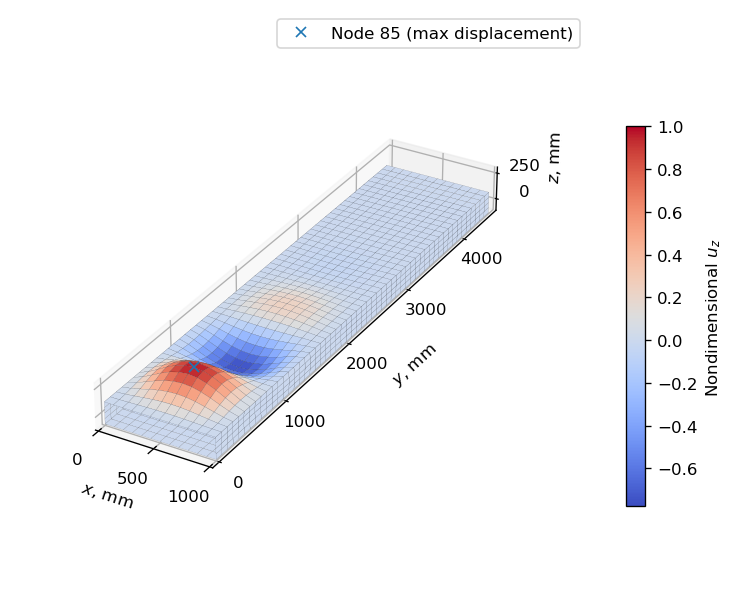

In [23]:
# Plot critical buckling mode
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=second_subcase_id, displacement_component='tz', colormap='coolwarm')

# Plot node of max displacement
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz + 200*sol_105_op2.eigenvectors[second_subcase_id].data[0, max_displacement_node_id - 1, 0:3]  # we multiply the eigenvector by the default displacement scale factor of plot_buckling_mode
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x', label=f'Node {max_displacement_node_id:d} (max displacement)', zorder=4)
ax.legend()

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(0, .14))  # move colorbar upwards

# Set axes ticks and labels' position and show plot
adjust_3d_plot(ax, cbar)
plt.show()

The last step before producing our 3D equilibrium diagram consists in finding the local displacement history at node 85 for the unstable path and for the natural path. For the latter we are going to use the results of the second subcase of the analysis with $EPSP=10^{-2}$, $EPSW=10^{-3}$.

In [24]:
_, _, local_displacements_2Psol105_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_2Psol105_epsp1em3,
displacement_node_id=max_displacement_node_id)
_, _, local_displacements_natural_path = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_2Psol105_epsp1em2,
displacement_node_id=max_displacement_node_id)

We can now produce our 3D equilibrium diagram.

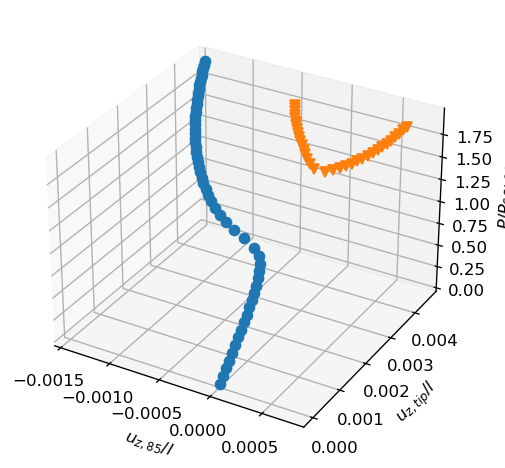

In [25]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot applied load against tip and local displacements
nondimensional_local_displacements = {0: local_displacements_natural_path[second_subcase_id][:, component_index]/l,
                                      1: local_displacements_2Psol105_epsp1em3[second_subcase_id][:, component_index]/l}
nondimensional_tip_displacements = {0: tip_displacements_2Psol105_epsp1em2[second_subcase_id][:, component_index]/l,
                                    1: tip_displacements_2Psol105_epsp1em3[second_subcase_id][:, component_index]/l}
nondimensional_applied_loads = {0: applied_loads_2Psol105_epsp1em2[second_subcase_id][:, component_index]/sol_105_buckling_load,
                                1: applied_loads_2Psol105_epsp1em3[second_subcase_id][:, component_index]/sol_105_buckling_load}
for key in nondimensional_local_displacements:
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key], nondimensional_applied_loads[key],
                 markers[key], color=colors[key])

# Set plot appearance
ax_3d.set_xlabel(f'$u_{{z, {max_displacement_node_id:d}}}/l$')
ax_3d.set_ylabel('$u_{z, tip}/l$')
ax_3d.set_zlabel('$P/P_\mathrm{SOL\/105}$')
ax_3d.grid(visible=True)
plt.show()

With this plot we can get a clear visualization of the disconnected nature of the equilibrium paths. However, we should remind that the equilibrium manifold of our box beam has actually as many dimensions as the number of the degrees of freedom plus one (representing the applied load). This means that our 3D equilibrium diagram is only an extremely partial representation of the equilibrium manifold and the fact that the paths appear disconnected for the investigated range of loads and displacements does not imply that the paths might not connect eslewhere in the equilibrium manifold. Nonetheless, this result is useful to make us aware that, while we are right to expect a stable natural path without bifurcations for a box beam with a concetrated load at the tip, we might jump on another path if the arc-length is large enough to allow the solver to do so.

What is the deformation shape along the different equilibrium paths? Let's explore this by cutting the equilibrium paths with a plane at $P/P_\text{SOL 105}=1.9$.

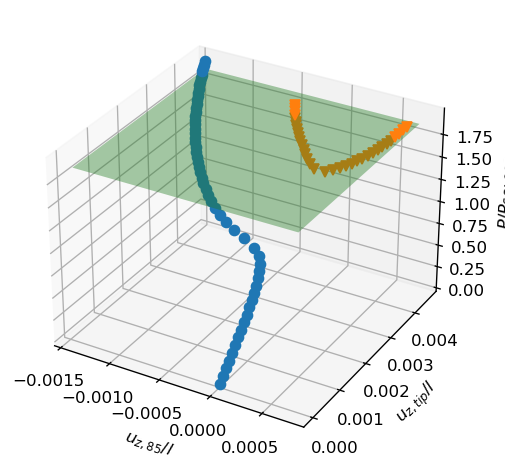

In [26]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot part of the equilibrium paths that should not be visible on top of the plane
load_factor = 1.9
for key in nondimensional_local_displacements:
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key] < load_factor, nondimensional_applied_loads[key], np.nan),
                 markers[key], color=colors[key])

# Plot P/Psol105=1.3 plane
local_displacements_array = np.concatenate(tuple(nondimensional_local_displacements[key] for key in nondimensional_local_displacements))
tip_displacements_array = np.concatenate(tuple(nondimensional_tip_displacements[key] for key in nondimensional_tip_displacements))
xx, yy = np.meshgrid([np.min(local_displacements_array), np.max(local_displacements_array)], [np.min(tip_displacements_array),
                                                                                              np.max(tip_displacements_array)])
ax_3d.plot_surface(xx, yy, np.full_like(xx, load_factor), alpha=0.4, color=colors[len(nondimensional_local_displacements)])

# Plot part of the equilibrium paths that should be visible on top of the plane
for key in nondimensional_local_displacements:
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key] >= load_factor, nondimensional_applied_loads[key], np.nan),
                 markers[key], color=colors[key], zorder=3)

# Set plot appearance
ax_3d.set_xlabel(f'$u_{{z, {max_displacement_node_id:d}}}/l$')
ax_3d.set_ylabel('$u_{z, tip}/l$')
ax_3d.set_zlabel('$P/P_\mathrm{SOL\/105}$')
ax_3d.grid(visible=True)
plt.show()

Let's plot the deformation shape at the closest equilibrium points to the $P/P_\text{SOL 105}=1.9$ plane.

Deformation on natural path:


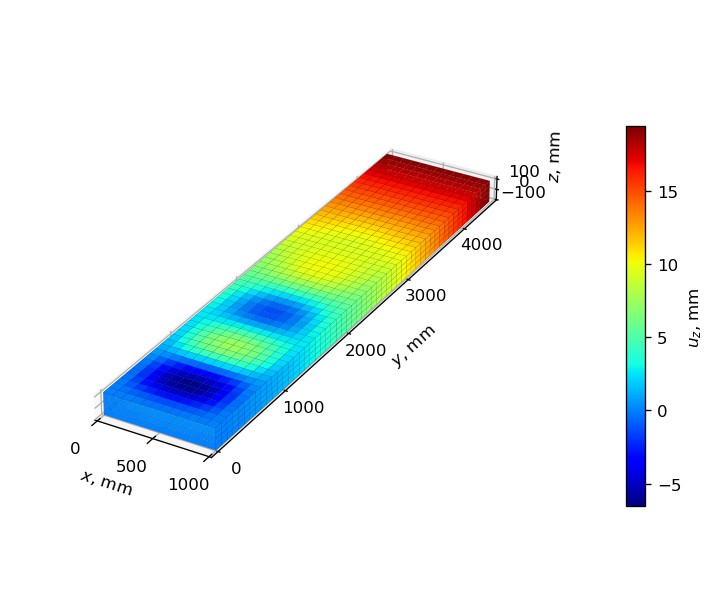

Deformations on unstable path:


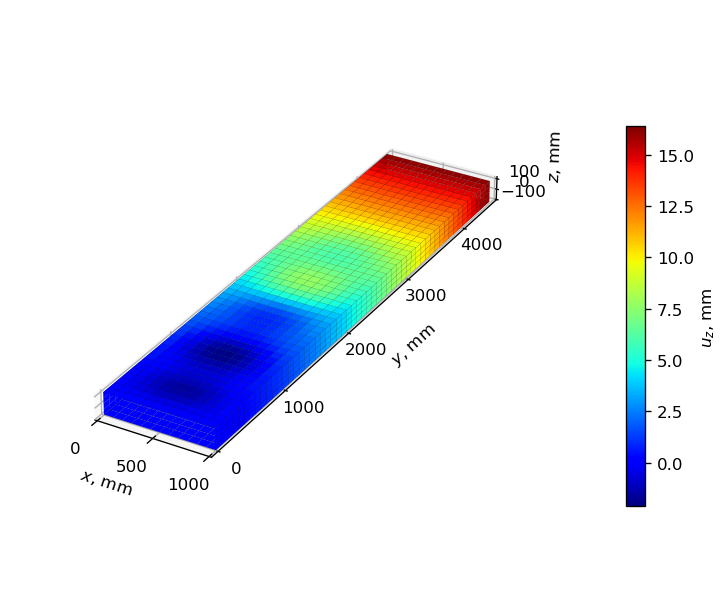

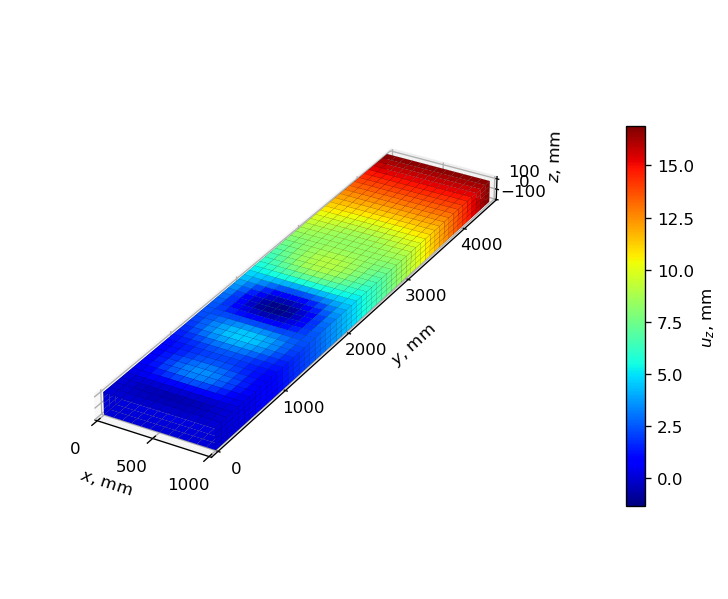

In [27]:
# Plot static deformation of natural path
print('Deformation on natural path:')
load_step = np.argmin(np.abs(nondimensional_applied_loads[0] - load_factor)) + 1  # find closest load step to plane
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_2Psol105_epsp1em2, subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

# Plot first deformation on unstable path
print('Deformations on unstable path:')
negative_displacements_indices = np.where(nondimensional_local_displacements[1] < np.median(nondimensional_local_displacements[1]))[0]
load_step = negative_displacements_indices[np.argmin(
    np.abs(nondimensional_applied_loads[1][negative_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_2Psol105_epsp1em3, subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

# Plot second deformation on unstable path
positive_displacements_indices = np.where(nondimensional_local_displacements[1] > np.median(nondimensional_local_displacements[1]))[0]
load_step = positive_displacements_indices[np.argmin(
    np.abs(nondimensional_applied_loads[1][positive_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_2Psol105_epsp1em3, subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

## Conclusions <a name="conclusions"></a>

***

In this notebook we have verified the existence of another equilibrium path of the unreinforced box beam beyond the natural path. More specifically, we were able to find an unstable path that resulted to be disconnected from the natural one. This was possible by choosing very coarse arc-length and by playing around with the convergence tolerances of the nonlinear analysis. We acknowledge that the procedure employed here is rather random, as there is no way to tell a priori whether the selection of a certain convergence tolerance will lead the arc-length solver to land on a stable or unstable path. Furthermore, our investigation does not represent by any means an exhaustive study on all other possible disconnected paths that might be present in the vicinity of the natural path. An appropriate tool would be needed to perform this study, as Nastran does not offer anything to do it in a systematic way. However, this is beyond the scope of our focus.

Nonetheless we gained useful insights and we were able to plot 3D equilibrium diagrams informing at the same time on the global and the local deformation state of the box beam. The tip displacement was used as a surrogate for the global state, while the displacement along $z$ of the node with the largest displacement predicted by the linear buckling analysis was used for the local state.

Overall, we understood that while we are right to expect a stable natural path without bifurcations for a box beam with a concetrated load at the tip, the solver might jump on another path if the arc-length is too large.

In the [next notebook](15_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs.ipynb) we will carry out an analogous investigation on the box beam reinforced with ribs.